# CLASSIFICATION OF LAB SAMPLES

This notebook contains the figures for the final classifier.
The classifier is constructed as follows:

* Features: 10 mycbactin genes plus 1 bacterioferritin gene
  * Mycobactin: Rv2377c, Rv2378c, Rv2379c, Rv2380c, Rv2381c, Rv2382c, Rv2383c, Rv2384, Rv2385    , Rv2386c
  * Bacterioferritin gene: Rv3841 
* Counts are averages of 3 replications
* Discard T1, the only normoixia timepoint

# TO DO

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common_python.util import dataframe
from tools.make_classification_data import ClassificationData
from tools.cross_validation_data import CrossValidationData

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

%matplotlib inline

In [2]:
# Add globals
names = ["REF_TYPE_BIOREACTOR", "REF_TYPE_POOLED", "REF_TYPE_SELF", "CLASSIFIER_DCT",
        "MYCOBACTIN_BACTERIOFERRIN_GENES",
        "SAMPLE_DCT", "TRINARY", "STAGE_NAMES", "GENE_DCT", "DATA_DCT", "T0", "DF_X_DCT",
        "SAMPLE_DATA_DCT", "STAGE_NAMES"]
data = ClassificationData()
NAMESPACE_DCT = data.getDct()
for name in names:
    stmt = "%s = NAMESPACE_DCT['%s']" % (name, name)
    exec(stmt)

In [3]:
# Default classifier is the preferred classifier
CLASSIFIER = CLASSIFIER_DCT[('pooled', 'mycobactin_bacterioferritin')]

In [4]:
DATA_DCT["pooled"].df_X.to_csv("pooled.csv", index=True)

## Constants

## Helper Functions

In [5]:
def evaluateClassifierOnInstances(clf, **kwargs):
    clf.evaluateClassifierOnInstances(**kwargs)

In [6]:
def plotSampleData(data_dct, genes= None, is_plot=True):
    """
    Plots trinary values of data for the specified genes.
    
    Parameters
    ----------
    data_dct: dict
        key: reference type
        value: sample dictionary
            key: sample name
            value: features
    genes: list-str
    """
    ref_types = list(data_dct.keys())
    sample_names = list(data_dct[ref_types[0]].keys())
    for sample_name in sample_names:
        for ref_type in ref_types:
            df_X = data_dct[ref_type][sample_name]
            if genes is None:
                genes = list(df_X.columns)
            TRINARY.plotExpressionLevels(genes, df_X=df_X, title=ref_type + ", " + sample_name, is_plot=is_plot)
            
# Tests
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES, is_plot=False)
print("OK!")

OK!


In [7]:
def reportSamplePredictions(data_dct):
    for name in data_dct.keys():
        df_X = data_dct[name]
        print("\n%s" % name)
        df_pred = CLASSIFIER.predict(df_X)
        new_columns = [STAGE_NAMES[c] for c in df_pred.columns]
        df_pred.columns = new_columns
        print(df_pred)

In [8]:
def plotAccuracy(genes, title="", selected_stages=None, size=100, is_plot=True, ax=None):
    """
    Plots the accuracy curve for a collection of genes
    
    Parameters
    ----------
    genes: list-str
    title: str
    selected_stages: list-str
        Create a binary classifier for just these tages
    size: int
    is_plot: bol
    """
    if ax is None:
        _, ax = plt.subplots(1)
    accuracy_dct = {}
    #data = mkDataSubset(genes, selected_stages=selected_stages)
    data = DATA_DCT[T0].subsetToStates(selected_stages, genes=genes)
    ranks = range(1, len(genes) + 1)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            data, num_iter=10, num_holdout=1, filter_high_rank=rank, size=size)
    ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()), marker="o")
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return accuracy_dct
    
# Tests
genes = GENE_DCT["bacterioferritin"]
accuracy_dct = plotAccuracy(GENE_DCT["bacterioferritin"], title=", ".join(genes),
                            selected_stages="StageII", size=5, is_plot=False)
assert(np.isclose(list(accuracy_dct.values())[0], 0.5))
print("OK!")

OK!


# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [9]:
# Plot accuracy for the number of genes for each classifier
if False:
    cv_data = CrossValidationData()
    colors = ["red", "brown", "blue", "black"]
    df_cv_data = cv_data.dataframe
    _, ax = plt.subplots(1, figsize=(18, 10))
    columns = list(df_cv_data.columns)
    keys = ["%s--%s" % (k.split("--")[1], k.split("--")[0]) for k in columns]
    df_new = df_cv_data.copy()
    df_new.columns = keys
    keys.sort()
    for idx, key in enumerate(keys):
        color_idx = idx//2
        parts = key.split("--")
        yvals = df_new[key].values
        ystds = np.sqrt(yvals*(1-yvals)/cv_data.num_clf)
        if parts[1] == "T0":
            linestyle = "--"
        else:
            linestyle = "-"
        ax.errorbar(range(1, len(yvals)+1), yvals, yerr=ystds, linestyle=linestyle,
                    color=colors[color_idx])
        ax.set_ylim([0, 1.1])
        _ = ax.set_xlabel("No genes in clasifier", fontsize=16)
        _ = ax.set_ylabel("accuracy", fontsize=16)
    _ = ax.legend(keys)

**TODO**: 
1. Verify values plotted for coefficients.
1. Fix the legend
1. Find the genes associated with each point and see the genes necessary to reach plateau.

# Classification of Samples

In [10]:
len(CLASSIFIER.features)

11

In [11]:
CLASSIFIER.predict(SAMPLE_DATA_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.00,1.00,0.00,0.00,0.00
AM_D20_3,0.00,1.00,0.00,0.00,0.00
AM_D20_4,0.00,1.00,0.00,0.00,0.00
AM_D20_5,0.00,1.00,0.00,0.00,0.00
MDM_D20_1,0.04,0.06,0.00,0.90,0.00
MDM_D20_3,0.90,0.00,0.00,0.06,0.04
MDM_D20_4,0.77,0.00,0.03,0.06,0.14
MDM_D20_5,0.00,1.00,0.00,0.00,0.00


In [13]:
#reportSamplePredictions(SAMPLE_DCT[REF_TYPE_SELF])

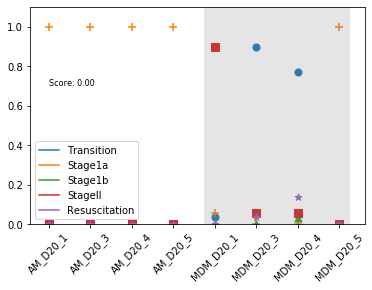

'SL1: 0.1360, SL0: 0.0010'

In [14]:
df_X = SAMPLE_DATA_DCT["AM_MDM"]
condition_strs = ["AM_D20", "MDM_D20"]
CLASSIFIER.plotConditions(df_X, condition_strs, STAGE_NAMES,
      state_probs=cn.STATE_PROBS,
      num_exp=8)

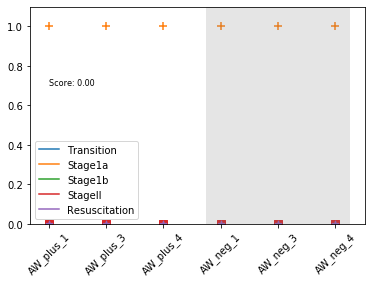

'SL1: 0.6380, SL0: 0.0150'

In [15]:
condition_strs = ["AW_plus", "AW_neg"]
df_X = SAMPLE_DATA_DCT["AW"]
CLASSIFIER.plotConditions(df_X, condition_strs, STAGE_NAMES,
      state_probs=cn.STATE_PROBS,
      num_exp=8) 

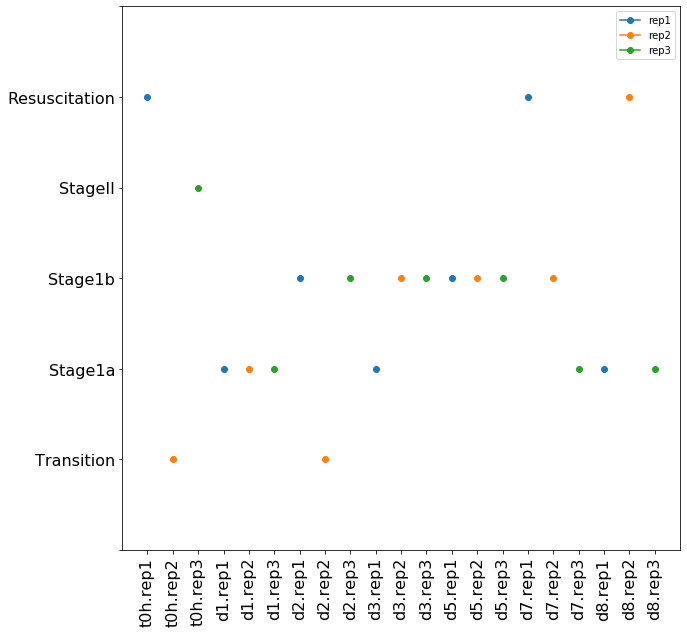

In [16]:
repl_strs = ["rep1", "rep2", "rep3"]
df_X = SAMPLE_DCT[REF_TYPE_SELF]["galagan"]
sel_indices = [i for i in df_X.index if "t0h" in i]
df_X.drop(index=sel_indices)
CLASSIFIER.plotProgression(df_X, repl_strs, list(df_X.index))

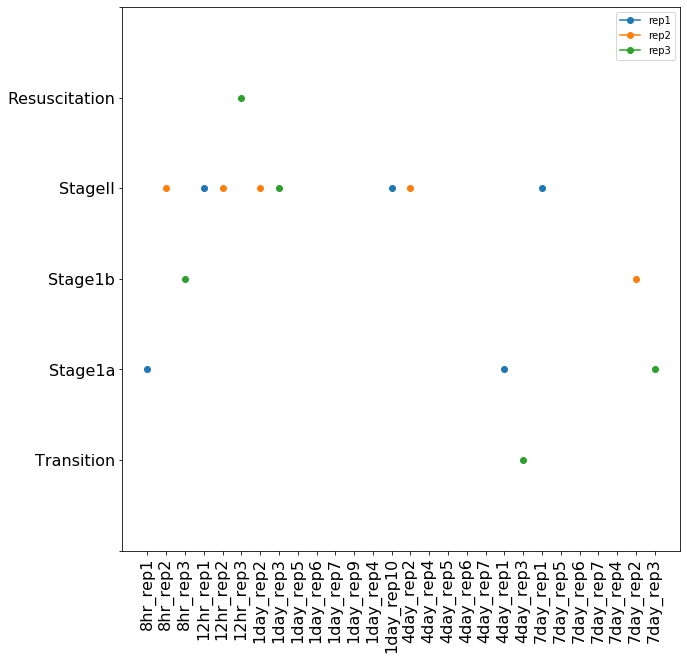

In [17]:
repl_strs = ["rep%d" % n for n in range(1, 4)]
df_X = SAMPLE_DCT[REF_TYPE_SELF]["rustad"].copy()
indices = [i.replace("H37Rv_hypoxia_", "") for i in df_X.index]
df_X.index = indices
drop_indices = [i for i in indices if "4hr" in i]
df_X = df_X.drop(index=drop_indices)
CLASSIFIER.plotProgression(df_X, repl_strs, list(df_X.index))